In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
import shap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.manifold import TSNE

In [2]:
df = pd.read_csv('processed_data2.csv')
df.fillna(0,inplace=True)
df[f'testb %al'],df['label'] = df['testb %al'],df['label']
X=df.drop(columns=['label'])
y=df['label']
y = y - 1
y.value_counts()

label
0    1002
1    1002
2    1002
3    1002
4    1002
Name: count, dtype: int64

In [3]:
num_others_data=1002
file1_idx=[i+num_others_data*j for i in range(1) for j in range(5)]
file2_idx=[i+num_others_data*j for i in range(1,2) for j in range(5)]
our_data_idx=[i+num_others_data*j for i in range(2) for j in range(5)]
print(f"{our_data_idx}")
print(f"{file1_idx}")
print(f"{file2_idx}")

[0, 1002, 2004, 3006, 4008, 1, 1003, 2005, 3007, 4009]
[0, 1002, 2004, 3006, 4008]
[1, 1003, 2005, 3007, 4009]


In [4]:
others_data_idx=df.index.difference(our_data_idx+file1_idx+file2_idx)
others_data_idx

Index([   2,    3,    4,    5,    6,    7,    8,    9,   10,   11,
       ...
       5000, 5001, 5002, 5003, 5004, 5005, 5006, 5007, 5008, 5009],
      dtype='int64', length=5000)

In [5]:
file1_data=X.iloc[file1_idx]
file2_data=X.iloc[file2_idx]
our_data=X.iloc[our_data_idx]
len(our_data),len(file1_data),len(file2_data)

(10, 5, 5)

In [8]:
tsne = TSNE(n_components=2, perplexity=2, random_state=42, n_jobs=-1)
X_tsne = tsne.fit_transform(X)
df_tsne = pd.DataFrame(X_tsne, columns=['Component 1', 'Component 2'])
df_tsne['label'] = y

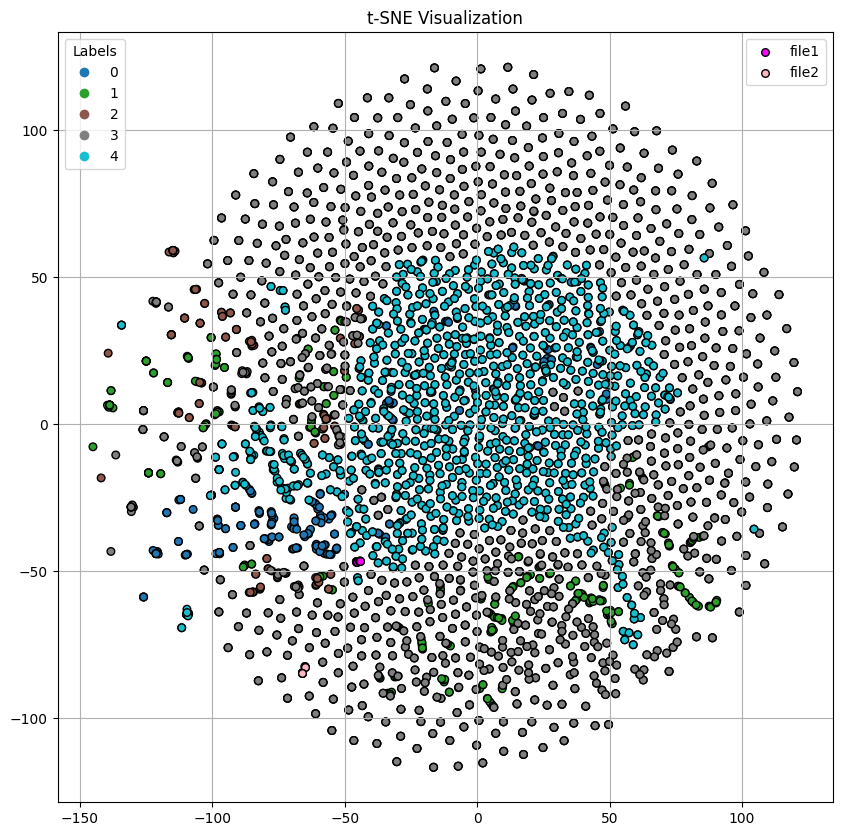

In [18]:
# 绘制 t-SNE 图像，使用标签 y 进行着色
plt.figure(figsize=(10,10))
s=30
scatter = plt.scatter(df_tsne['Component 1'],
                      df_tsne['Component 2'],
                      c=df_tsne['label'],
                      cmap='tab10',
                      marker='o',
                      edgecolor='k',
                      s=s)
plt.scatter(df_tsne.loc[file1_idx]['Component 1'],
            df_tsne.loc[file1_idx]['Component 2'],
            c='fuchsia',
            marker='o',
            edgecolor='k',
            label='file1',
            s=s)
plt.scatter(df_tsne.loc[file2_idx]['Component 1'],
            df_tsne.loc[file2_idx]['Component 2'],
            c='lightpink',
            marker='o',
            label='file2',
            edgecolor='k',
            s=s)



legend1 = plt.legend(*scatter.legend_elements(), title="Labels", loc='upper left')
plt.gca().add_artist(legend1)
plt.legend(loc='upper right')
plt.title('t-SNE Visualization')
plt.grid(True)
plt.show()

In [130]:
from xgboost import XGBClassifier
import warnings
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
)
warnings.filterwarnings('ignore')
xgb_params = {
    "objective": "binary:logistic",  # 目标函数：二分类逻辑回归
    "max_depth": 50,  # 树的最大深度
    "eta": 0.4,  # 学习率
    "subsample": 1,  # 采样率
    'sampling_method': 'uniform',  # 采样算法,uniform:均匀采样,gradient_based:梯度采样
    "colsample_bytree": 1,  # 构建每棵树时，使用特征的比例
    "colsample_bylevel": 1,  # 树的每一级的每一次分裂，对特征的采样比例
    "reg_lambda": 1,  # L2 正则化
    "reg_alpha": 1,  # L1 正则化
    "min_child_weight": 1,  # 最小的叶子节点样本权重和
    "gamma": 0,  # 节点分裂所需的最小损失函数减少量
    "eval_metric": "logloss",  # 评估指标：对数损失
    "scale_pos_weight": 1,  # 用于处理类别不平衡 negative:positive
    "tree_method": "hist",  # 树构建算法 ['exact', 'approx', 'hist', 'gpu_hist']
    'device': 'gpu',
    "nthread": -1,  # 使用所有可用线程
    # "seed":42,  # 随机数种子
    "n_estimators": 100,  # 决策树个数
    "booster": "gbtree",  # 基本模型
    'max_delta_step': 0,  # 限制每棵树权重改变的最大步长,0表示没有约束
}
model = XGBClassifier(**xgb_params)
model.fit(X_train, y_train)
1

1

Text(0.5, 1.0, 'Confusion Matrix')

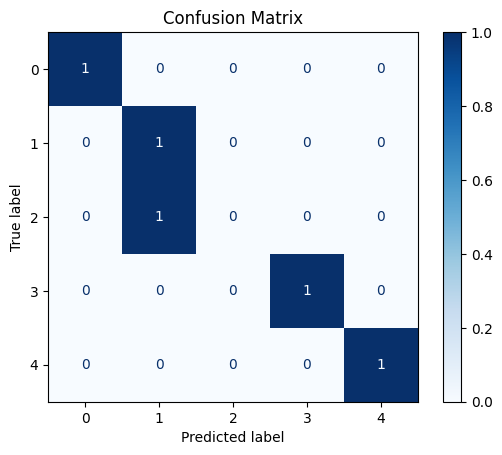

In [131]:
y_pred=model.predict(X)
y_pred_ours=y_pred[file2_idx]
cm = confusion_matrix(y[file2_idx], y_pred_ours)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title('Confusion Matrix')

In [ ]:
import xgboost

xgboosts = xgboost.to_graphviz(model, num_trees=99)
xgboosts.format = 'png'
xgboosts.view('./xgboost')

In [132]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       185
           1       0.99      0.99      0.99       197
           2       0.94      0.98      0.96       192
           3       0.99      0.95      0.97       204
           4       1.00      1.00      1.00       224

    accuracy                           0.99      1002
   macro avg       0.99      0.99      0.98      1002
weighted avg       0.99      0.99      0.99      1002



In [ ]:
from sklearn.model_selection import  cross_val_score
from sklearn.model_selection import KFold
kfold=KFold(n_splits=10,shuffle=True,random_state=42)
scores = cross_val_score(model, X, y, cv=kfold, scoring='accuracy', n_jobs=-1)
print(scores)

[0.98602794 0.98602794 0.99001996 0.9740519  0.98403194 0.9740519
 0.99001996 0.99600798 0.98802395 0.98602794]
